In [1]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from numba import jit

import sys
sys.path.insert(0, '../fem')
from grf import GRF

In [484]:
l = 0.4
N_gridpoints = 11#int(1/l) + 1
X, Y = np.mgrid[0:1:N_gridpoints*1j, 0:1:N_gridpoints*1j]
x_grid = np.vstack([X.ravel(), Y.ravel()]).T
cov = np.exp(-distance_matrix(x_grid,x_grid, p=2)**2/(2*l**2))

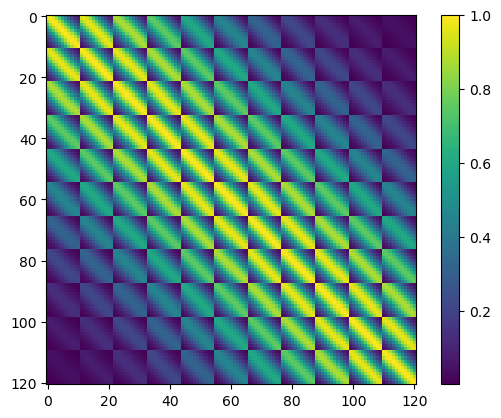

In [485]:
plt.imshow(cov)
plt.colorbar()

In [486]:
# f = np.random.multivariate_normal(np.zeros(N_gridpoints**2), cov=cov, size=1)
f = np.random.multivariate_normal(np.zeros(N_gridpoints**2), cov=np.identity(N_gridpoints**2), size=1)
# if np.sum(f<0)>0:
#     f = f - np.amin(f) + 0.02

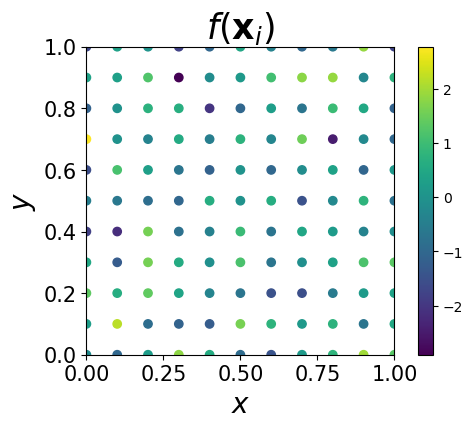

In [487]:
size_title = 25
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.scatter(x_grid[:,0], x_grid[:,1], c=f[0])
ax.set_title(r"$f(\mathbf{x}_i)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("2dgrfdelta.svg", bbox_inches='tight')

In [488]:
def RBFinterpolation(f, x_grid, cov, l):
    f_hat = np.dot(np.linalg.inv(cov),f[0])
    l_int = 0.2
    def function(x):
        terms = f_hat*np.exp(-np.sum((x - x_grid)**2, axis=-1)/(2*l_int**2))
        terms = terms[np.argsort(np.abs(terms))]
        return np.sum(terms)
        # return np.sum(f_hat*np.exp(-np.sum((x - x_grid)**2, axis=-1)/(2*l**2)))
    
    return function

function = RBFinterpolation(f, x_grid, cov, l)

In [489]:
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T

In [490]:
f_i = np.zeros(len(x_i))
for i in range(len(x_i)):
    f_i[i] = function(x_i[i])

0.4954


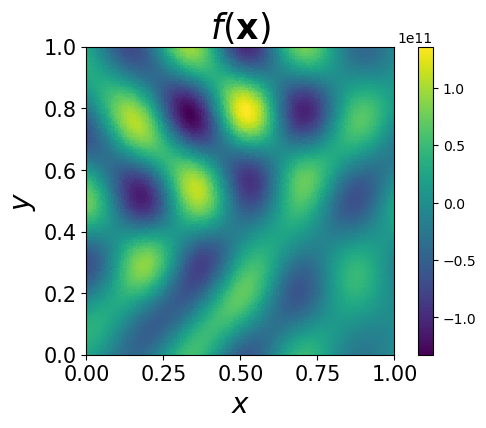

In [491]:
size_title = 25
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.tripcolor(x_i[:,0], x_i[:,1], f_i)
ax.set_title(r"$f(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("2dRBFint.svg", bbox_inches='tight')
print(np.sum(f_i<0)/len(f_i))

In [182]:
plt.hist(f_gauss, bins=50, density=True)
plt.hist(f_i, bins=50, density=True)

NameError: name 'f_gauss' is not defined

In [183]:
def compute_GRFpoints(l):    
    
    N_gridpoints = int(1/l) + 1
    X, Y = np.mgrid[0:1:N_gridpoints*1j, 0:1:N_gridpoints*1j]
    x_grid = np.vstack([X.ravel(), Y.ravel()]).T
    cov = np.exp(-distance_matrix(x_grid,x_grid, p=2)**2/(2*l**2))
    f = np.random.multivariate_normal(np.zeros(N_gridpoints**2), cov=cov, size=1)[0]
    
    return cov, x_grid, f

In [184]:
l = 0.2
cov, x_grid, f = compute_GRFpoints(l)

In [186]:
def RBFinterpolation(l, cov, x_grid, f):

    f_hat = np.dot(np.linalg.inv(cov),f)
    
    def function(x):
        terms = f_hat*np.exp(-np.sum((x - x_grid)**2, axis=-1)/(2*l**2))
        # terms = f_hat*np.exp(-np.sum((x[:,None,:] - x_grid[None,:,:])**2, axis=-1)/(l**2))
        return np.sum(terms)
        return np.sum(terms, axis=1)
    
    return function

In [287]:
class GRF():
    def __init__(self, d, l, N_samples, lowerbound, upperbound):
        super().__init__()
        self.d = d
        self.l = l
        self.lowerbound = lowerbound
        self.upperbound = upperbound
        self.N_samples = N_samples
        self.N_gridpoints = int(1/self.l) + 1
        self.compute_grid()
        self.compute_cov()
        self.compute_GRFpoints()
        self.compute_RBFintcoeffs()
        self.compute_minmax()
        
    def compute_grid(self):
        if self.d==1:
            self.x_grid = np.linspace(0,1,self.N_gridpoints).reshape((self.N_gridpoints,1))
        if self.d==2:
            X, Y = np.mgrid[0:1:self.N_gridpoints*1j, 0:1:self.N_gridpoints*1j]
            self.x_grid = np.vstack([X.ravel(), Y.ravel()]).T
    
    def compute_cov(self):
        self.cov = np.exp(-distance_matrix(self.x_grid, self.x_grid, p=2)**2/(2*self.l**2))
    
    def compute_GRFpoints(self):
        self.f = np.random.multivariate_normal(np.zeros(self.N_gridpoints**self.d), cov=self.cov, size=self.N_samples)
    
    def compute_RBFintcoeffs(self):
        cov_inv = np.linalg.inv(self.cov)
        self.f_hat = np.einsum('nij,nj->ni', np.tile(cov_inv, (self.f.shape[0],1,1)), self.f)
    
    def RBFint(self, x):
        if self.d==1:
            x = x.reshape((len(x),1))
        terms = self.f_hat[:,:,None]*np.exp(-np.sum((x[None,None,:,:] - self.x_grid[None,:,None,:])**2, axis=-1)/(2*self.l**2))
        output = np.sum(terms, axis=1)
        return output

    def RBFint_pointwise(self, sample):
        terms = self.f_hat*np.exp(-np.sum((x - self.x_grid)**2, axis=-1)/(2*self.l**2))
        output = np.sum(terms, axis=1)
        return output
    
    def compute_minmax(self):
        if self.d==1:
            x = np.linspace(0,1,100)
            self.f_min = np.amin(self.RBFint(x))
            self.f_max = np.amax(self.RBFint(x))
        if self.d==2:
            X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
            x = np.vstack([X.ravel(), Y.ravel()]).T
            self.f_min = np.amin(self.RBFint(x))
            self.f_max = np.amax(self.RBFint(x))
            
    def RBFint_scaled(self, x):
        output_scaled = (self.RBFint(x) - self.f_min)/(self.f_max - self.f_min) #Scale to [0,1]
        output_scaled = (self.upperbound - self.lowerbound)*output_scaled + self.lowerbound #Scale to [lowerbound,upperbound]
        return output_scaled
            
    def RBFint_pointwise_scaled(self, x):
        output_scaled = (self.RBFint_pointwise(x) - self.f_min)/(self.f_max - self.f_min) #Scale to [0,1]
        output_scaled = (self.upperbound - self.lowerbound)*output_scaled + self.lowerbound #Scale to [lowerbound,upperbound]
        return output_scaled
    
    def sample(self, f, i):
        def function(x):
            return f(x)[i]
        return function

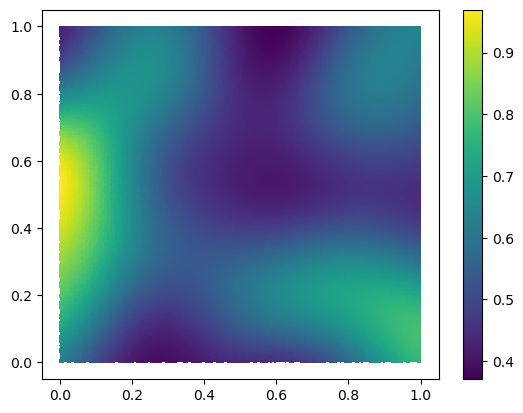

In [324]:
GRFset = GRF(d=2,l=0.2, N_samples=10, lowerbound=0.02, upperbound=0.99)
func = GRFset.RBFint_scaled
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T
func(x_i).shape
plt.tripcolor(x_i[:,0], x_i[:,1], func(x_i)[0])
plt.colorbar()

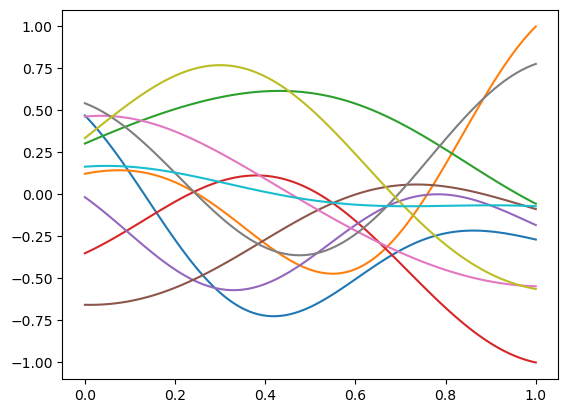

In [325]:
grf = GRF(d=1, l=0.3, N_samples=10, lowerbound=-1, upperbound=1)
func = grf.RBFint_scaled
x_i = np.linspace(0,1,100)
func(x_i).shape
for i in range(10):
    
    plt.plot(x_i, func(x_i)[i])

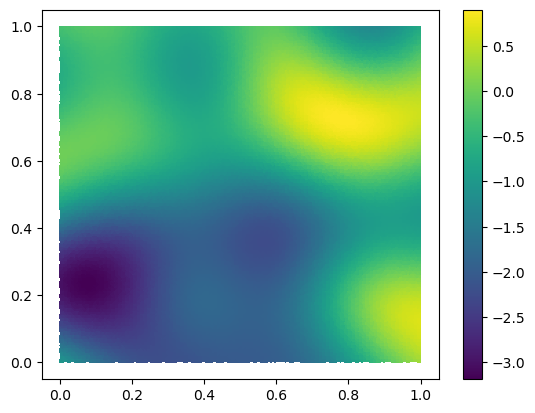

ValueError: x and y must have same first dimension, but have shapes (100,) and (1000, 100)

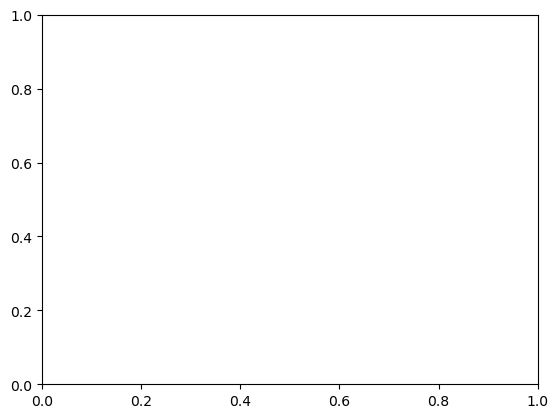

In [163]:
func = grf.RBFint
x_i = np.linspace(0,1,100)
func(x_i).shape
plt.plot(x_i, func(x_i))

In [418]:
def normalized_gp_samples(NN, n_samples, length_scale, output_scale, gp_min):
    # GRF sample generation
    def RBF(x, length_scale, output_scale):
        N = x.shape[0]
        dist_mat = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                dist_mat[i,j] = np.linalg.norm(x[i,:] - x[j,:])
        r = (dist_mat/length_scale)**2        
        return output_scale * np.exp(-0.5 * r)

    X = np.zeros([NN**2, 2])
    xv, yv = np.meshgrid(np.linspace(0, 1, NN), np.linspace(0, 1, NN))
    X[:,0] = xv.flatten()
    X[:,1] = yv.flatten()
    
    K = RBF(X, length_scale, output_scale)
    plt.imshow(K)
    plt.show()
    L = np.linalg.cholesky(K + 1e-10*np.eye(NN**2))
    plt.imshow(L)
    plt.show()
    gp_samples = (L @ np.random.randn(NN**2, n_samples)) + gp_min
    min_v, max_v = gp_samples.min(), gp_samples.max()

    #normalized_sm = gp_samples
    normalized_sm = (gp_samples - min_v)/(max_v - min_v) + gp_min * (1 - (gp_samples - min_v)/(max_v - min_v))
    return normalized_sm

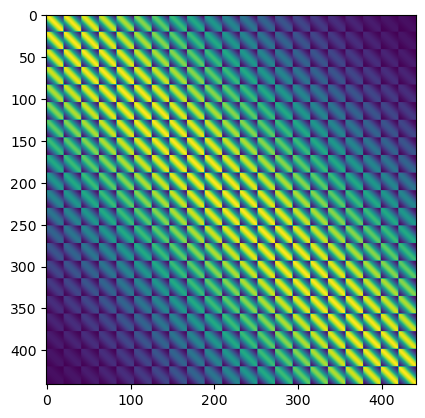

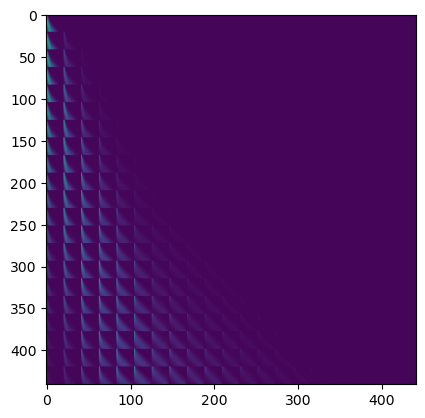

(441, 1)

In [419]:
NN = 21
n_samples = 1
length_scale = 0.4
output_scale = 1
gp_min = 0

X = np.zeros([NN**2, 2])
xv, yv = np.meshgrid(np.linspace(0, 1, NN), np.linspace(0, 1, NN))
X[:,0] = xv.flatten()
X[:,1] = yv.flatten()

g = normalized_gp_samples(NN, n_samples, length_scale, output_scale, gp_min)
g.shape

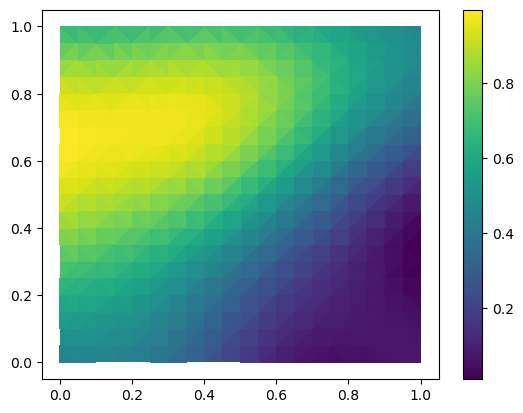

In [420]:
plt.tripcolor(X[:,0], X[:,1], g[:,0])
plt.colorbar()

In [421]:
l = 0.4
N_gridpoints = 21#int(1/l) + 1
X, Y = np.mgrid[0:1:N_gridpoints*1j, 0:1:N_gridpoints*1j]
x_grid = np.vstack([X.ravel(), Y.ravel()]).T
cov = np.exp(-distance_matrix(x_grid,x_grid, p=2)**2/(l**2))

(441, 441)


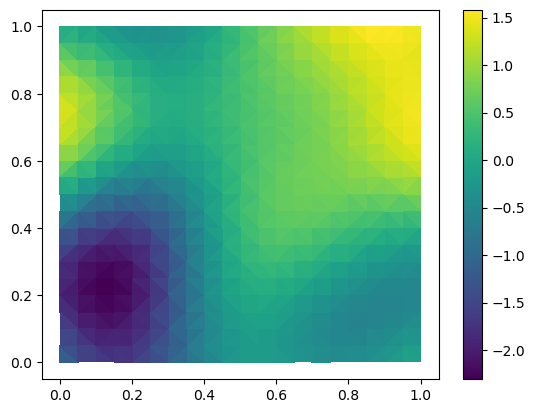

In [422]:
L = np.linalg.cholesky(cov + 1e-10*np.eye(cov.shape[0]))
print(L.shape)
rand = np.random.normal(0,1,size=cov.shape[0])
f = L @ rand
plt.tripcolor(x_grid[:,0], x_grid[:,1], f)
plt.colorbar()

(array([0.11494536, 0.11494536, 0.11494536, 0.1436817 , 0.08620902,
        0.08620902, 0.20115437, 0.08620902, 0.20115437, 0.1436817 ,
        0.02873634, 0.1436817 , 0.1436817 , 0.11494536, 0.08620902,
        0.05747268, 0.02873634, 0.20115437, 0.17241804, 0.05747268,
        0.02873634, 0.05747268, 0.60346312, 0.43104509, 0.37357241,
        0.51725411, 0.45978143, 0.45978143, 0.51725411, 0.43104509,
        0.54599045, 0.45978143, 0.31609973, 0.45978143, 0.37357241,
        0.43104509, 0.43104509, 0.45978143, 0.43104509, 0.40230875,
        0.25862705, 0.20115437, 0.17241804, 0.28736339, 0.20115437,
        0.11494536, 0.25862705, 0.37357241, 0.20115437, 0.08620902]),
 array([-2.31296827, -2.23405865, -2.15514903, -2.07623941, -1.99732978,
        -1.91842016, -1.83951054, -1.76060091, -1.68169129, -1.60278167,
        -1.52387205, -1.44496242, -1.3660528 , -1.28714318, -1.20823355,
        -1.12932393, -1.05041431, -0.97150468, -0.89259506, -0.81368544,
        -0.73477582, -0.65

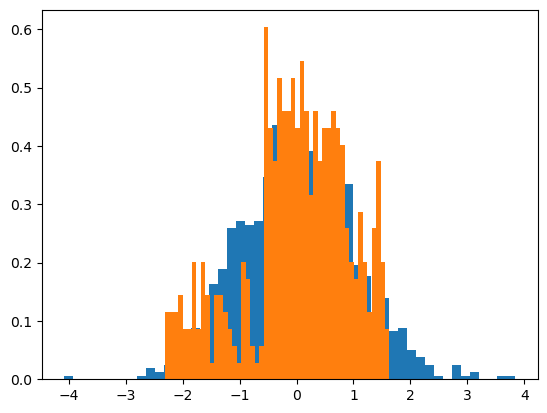

In [423]:
f_gauss = np.random.normal(0,1,1000)
plt.hist(f_gauss, bins=50, density=True)
plt.hist(f, bins=50, density=True)